# Data Process

In [6]:
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!java -version
!pip install py_vncorenlp
!pip install vncorenlp

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 https://packages.cloud.google.com/apt gcsfuse-focal InRelease            
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease    
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]
Hit:6 https://packages.cloud.google.com/apt google-fast-socket InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Fetched 6361 B in 1s (5260 B/s)
Reading package lists... Done
openjdk version "11.0.22" 2024-01-16
OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu220.04.1)
OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu220.04.1, mixed mode, sharing)


In [7]:
import pandas as pd
from datasets import load_dataset

data_files = {
    'train': '/kaggle/input/sentiment-analysis/data/data/vi/train_datasets.csv',
    'test': '/kaggle/input/sentiment-analysis/data/data/vi/test_datasets.csv',
}

dataset = load_dataset('csv', data_files=data_files)

In [8]:
from vncorenlp import VnCoreNLP
from transformers import AutoTokenizer

rdrsegmenter = VnCoreNLP('/kaggle/input/sentiment-analysis/vncorenlp/vncorenlp/VnCoreNLP-1.1.1.jar', annotators="wseg", max_heap_size='-Xmx500m')

In [9]:
import numpy as np
import re

def strip_emoji(text):
    RE_EMOJI = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    return RE_EMOJI.sub(r'', text)

def remove_special_char(text):
    special_character = re.compile("�+")
    return special_character.sub(r'', text)

def remove_punctuation(text):
    punctuation = re.compile(r"[!#$%&()*+;<=>?@[\]^_`{|}~]")
    return punctuation.sub(r"", text)

def remove_number(text):
    return re.sub(" \d+", " ", text)

def normalize_annotatation(text):
    khach_san = "\bkhach san ?|\bksan ?|\bks ?"
    return re.sub("\bnv ?", "nhân viên",re.sub(khach_san, "khách sạn", text))

def clean_text(text):
    return {"Review": normalize_annotatation(remove_number(remove_special_char(remove_punctuation(strip_emoji(text["Review"].lower())))))}

feature = ['giai_tri', 'luu_tru', 'nha_hang', 'an_uong', 'di_chuyen', 'mua_sam']
def label(text):
    return {'labels_regressor': np.array([text[i] for i in feature]),
        'labels_classifier': np.array([int(text[i] != 0) for i in feature])}

def token2id(dataset, max_seq_len):
    token_ids_dataset = {
        'train': {'input_ids': [], 'labels_regressor': [], 'labels_classifier': []},
        'test': {'input_ids': [], 'labels_regressor': [], 'labels_classifier': []}
    }

    for split in ['train', 'test']:
        for review, labels_regressor, labels_classifier in zip(dataset[split]['Review'], dataset[split]['labels_regressor'], dataset[split]['labels_classifier']):
            input_ids = tokenize(review, max_seq_len)
            
            token_ids_dataset[split]['input_ids'].append(input_ids)
            token_ids_dataset[split]['labels_regressor'].append(labels_regressor)
            token_ids_dataset[split]['labels_classifier'].append(labels_classifier)

    return token_ids_dataset

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Review', 'giai_tri', 'luu_tru', 'nha_hang', 'an_uong', 'di_chuyen', 'mua_sam'],
        num_rows: 4299
    })
    test: Dataset({
        features: ['Unnamed: 0', 'Review', 'giai_tri', 'luu_tru', 'nha_hang', 'an_uong', 'di_chuyen', 'mua_sam'],
        num_rows: 1074
    })
})

In [11]:
dataset = dataset.map(label)

Map:   0%|          | 0/4299 [00:00<?, ? examples/s]

Map:   0%|          | 0/1074 [00:00<?, ? examples/s]

In [12]:
dataset = dataset.remove_columns(['Unnamed: 0', 'giai_tri', 'luu_tru', 'nha_hang', 'an_uong', 'di_chuyen', 'mua_sam'])

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Review', 'labels_regressor', 'labels_classifier'],
        num_rows: 4299
    })
    test: Dataset({
        features: ['Review', 'labels_regressor', 'labels_classifier'],
        num_rows: 1074
    })
})

In [14]:
from torchtext.vocab import build_vocab_from_iterator

reviews = dataset['train']['Review']
reviews.extend(dataset['test']['Review'])

def get_tokens(data_iter):
    for review in data_iter:
        sentence = rdrsegmenter.tokenize(review)
        for token in sentence:
            yield [word for word in token]

vocab = build_vocab_from_iterator(
    get_tokens(reviews),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])
len(vocab)

6984

In [15]:
tokenized_data = token2id(dataset, max_seq_len=64)

In [16]:
vocab.get_stoi()

{'🤤🤤🤤': 6981,
 '🤣🤣🤣': 6980,
 '🤣🤣': 6979,
 '🤗': 6978,
 '😬': 6977,
 '😩': 6976,
 '😥': 6975,
 '😝😝': 6974,
 '😝': 6973,
 '😑': 6971,
 '😌😌': 6970,
 '😅😅😅': 6965,
 '😂😂😂': 6964,
 '😁😁': 6963,
 '🔆': 6962,
 '👍👍👍👍👍': 6961,
 '🍸🍹🍦🍵🍶🍷': 6960,
 '🍒Giá': 6959,
 '🌼Vì': 6958,
 '⭐️⭐️Ngày': 6957,
 'Ừ': 6953,
 'ức': 6951,
 'ớn': 6949,
 'ổng': 6948,
 'ổn_áp': 6947,
 'ồ': 6944,
 'Ồ.': 6943,
 'ốc_bươu': 6942,
 'ố': 6941,
 'ầm_ĩ': 6934,
 'ầm': 6933,
 'Ấy': 6932,
 'ảo_tưởng': 6931,
 'ươn': 6930,
 'động❤️❤️': 6922,
 'đồng_hành': 6920,
 'đồng_bộ': 6919,
 'địa_đạo': 6917,
 'địa_thế': 6916,
 'địa': 6914,
 'đề': 6912,
 'đến_cùng': 6911,
 'đặt_để': 6910,
 'đầy_ắp': 6908,
 'đầu_lưỡi': 6907,
 'đạo_đức': 6905,
 'đại_khái': 6904,
 'được.có': 6902,
 'đường_thuỷ': 6899,
 'đương_nhiên': 6897,
 'đương': 6896,
 'đươc': 6895,
 'đưa_rước': 6893,
 'đăc': 6890,
 'đút': 6889,
 'đúng_đắn': 6888,
 'đúng_mức': 6887,
 'đón_nhận': 6880,
 'đít': 6879,
 'đích_thực': 6878,
 'đê': 6876,
 'đây.đồ': 6875,
 'đâng': 6874,
 'đâm_ra': 6873,
 'đánh_bà

In [17]:
vocab(['hài_lòng'])

[241]

In [18]:
def tokenize(review, max_seq_len):
    sentences = rdrsegmenter.tokenize(review)
    sequence = []
    for sentence in sentences:
        for token in sentence:
            sequence.extend(vocab([token]))
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence

example_question = "Mình thực sự rất thích sản phẩm. Chào bạn."
max_seq_len = 32

tokenize(example_question, max_seq_len)

[70,
 378,
 8,
 94,
 697,
 5,
 3,
 32,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [19]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Review', 'labels_regressor', 'labels_classifier'],
        num_rows: 4299
    })
    test: Dataset({
        features: ['Review', 'labels_regressor', 'labels_classifier'],
        num_rows: 1074
    })
})

In [20]:
tokenized_data = token2id(dataset, max_seq_len=64)

In [21]:
next(iter(dataset['train']))

{'Review': 'Lần sau mình sẽ dẫn bạn bè mình tới đây dài dài luôn',
 'labels_regressor': [0, 0, 0, 0, 0, 0],
 'labels_classifier': [0, 0, 0, 0, 0, 0]}

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):  # Inherits from Dataset correctly
    def __init__(self, tokenized_data, split):
        self.input_ids = tokenized_data[split]['input_ids']
        self.labels_regressor = tokenized_data[split]['labels_regressor']
        self.labels_classifier = tokenized_data[split]['labels_classifier']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'labels_regressor': torch.tensor(self.labels_regressor[idx], dtype=torch.float),
            'labels_classifier': torch.tensor(self.labels_classifier[idx], dtype=torch.long)
        }


In [27]:
# Tạo instance của ReviewDataset cho tập huấn luyện và tập kiểm thử
train_dataset = ReviewDataset(tokenized_data, 'train')
test_dataset = ReviewDataset(tokenized_data, 'test')

# Tạo DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [28]:
next(iter(test_dataloader))

{'input_ids': tensor([[ 247,   16,   43,  ...,    0,    0,    0],
         [ 611,  984,  105,  ...,    0,    0,    0],
         [  83,  203,   98,  ...,  431, 3769,   13],
         ...,
         [ 862, 2671,  771,  ...,    0,    0,    0],
         [ 195,  102, 4814,  ...,    0,    0,    0],
         [ 776,   58,   40,  ...,  551,  172,   11]]),
 'labels_regressor': tensor([[5., 0., 5., 5., 0., 0.],
         [0., 0., 0., 0., 3., 0.],
         [0., 0., 0., 2., 0., 0.],
         [0., 0., 0., 0., 0., 4.],
         [0., 0., 5., 5., 0., 0.],
         [0., 0., 0., 5., 0., 0.],
         [4., 0., 0., 0., 0., 0.],
         [0., 0., 0., 4., 0., 0.],
         [0., 0., 0., 0., 0., 4.],
         [0., 4., 0., 0., 0., 0.],
         [4., 0., 0., 4., 0., 0.],
         [0., 5., 0., 0., 0., 0.],
         [4., 0., 0., 0., 0., 0.],
         [0., 3., 0., 0., 0., 0.],
         [0., 0., 5., 5., 0., 0.],
         [4., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 4., 0.],
         [0., 0., 1., 0., 0., 0.],
   

# Model

In [38]:
import torch.nn as nn

class BLSTModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.bi_lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.bi_gru = nn.GRU(hidden_dim * 2, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)  # Note hidden_dim * 2 because LSTM is bidirectional
               
        self.linear = nn.Sequential(nn.Linear(768*4, 768),
                                    nn.SiLU(),
                                    nn.BatchNorm1d(768),
                                    nn.Dropout(0.4),
                                    nn.Linear(768, 768//4),
                                    nn.SiLU(),
                                    nn.BatchNorm1d(768//4),
                                    nn.Dropout(0.4)
                                   )
        self.skip = nn.Sequential(nn.Linear(768*4, 768//4),
                                    nn.Dropout(0.3),
                                    nn.SiLU()
                                 )
        self.classifier = nn.Linear(768//4, 6)
        self.regressor = nn.Linear(768//4, 30)

    def forward(self, x):
        x = self.embedding(x)
        output1, (hidden, cell) = self.bi_lstm(x)
        output2, hidden2 = self.bi_gru(output1)  # Changed to output1

        last_hidden = torch.cat((hidden[-1,:,:], hidden[-2,:,:], hidden2[-1,:,:], hidden2[-2,:,:]), dim=1)
        
        output = self.linear(last_hidden)
        skip = self.skip(last_hidden)
        
        output = output + skip

        classifier_out = self.classifier(output)
        regressor_out = self.regressor(output)

        classifier_out = nn.Sigmoid()(classifier_out)
        regressor_out = regressor_out.reshape(-1, 6, 5)  # Ensure this reshape aligns with your expected output format

        return classifier_out, regressor_out


In [39]:
vocab_size = 6984

model = BLSTModel(vocab_size=vocab_size, 
                     emb_dim=128, 
                     hidden_dim=768,
                     num_layers=2
                     )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
model.to(device)

BLSTModel(
  (embedding): Embedding(6984, 128)
  (bi_lstm): LSTM(128, 768, num_layers=2, batch_first=True, bidirectional=True)
  (bi_gru): GRU(1536, 768, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Sequential(
    (0): Linear(in_features=3072, out_features=768, bias=True)
    (1): SiLU()
    (2): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=768, out_features=192, bias=True)
    (5): SiLU()
    (6): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
  )
  (skip): Sequential(
    (0): Linear(in_features=3072, out_features=192, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): SiLU()
  )
  (classifier): Linear(in_features=192, out_features=6, bias=True)
  (regressor): Linear(in_features=192, out_features=30, bias=True)
)

# Training

### Loss

In [32]:
import torch.nn.functional as F
import torch
import torch.nn as nn

def loss_classifier(pred_classifier, labels_classifier):
    return nn.BCELoss()(pred_classifier, labels_classifier)

def loss_regressor(pred_regressor, labels_regressor):
    mask = (labels_regressor != 0)
    loss = ((pred_regressor - labels_regressor)**2)[mask].sum() / mask.sum()
    return loss

def loss_softmax(inputs, labels, device):
    mask = (labels != 0)
    # inputs (N, 6, 5)
    n, aspect, rate = inputs.shape
    num = 0
    loss = torch.zeros(labels.shape).to(device)
    for i in range(aspect):
        label_i = labels[:, i].clone()
        label_i[label_i != 0] -= 1
        label_i = label_i.type(torch.LongTensor).to(device)
        loss[:, i] = nn.CrossEntropyLoss(reduction='none')(inputs[:, i, :], label_i)
    loss = loss[mask].sum() / mask.sum()
    return loss

def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "none",):

    # p = torch.sigmoid(inputs)
    p = inputs
    ce_loss = F.binary_cross_entropy(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

def bce_loss_weights(inputs, targets, weights):
    ce_loss = F.binary_cross_entropy(inputs, targets, reduction="none")
    weights = targets*(1 / weights.view(1, -1)) + (1 - targets)*(1 / (1 - weights.view(1, -1)))
    loss = ce_loss*weights
    return loss.mean()


def CB_loss(inputs, targets, samples_positive_per_cls, samples_negative_per_cls, no_of_classes=2,loss_type='sigmoid', beta=0.9999, gamma=2):
    samples_per_cls = torch.concat([samples_positive_per_cls.unsqueeze(-1), samples_negative_per_cls.unsqueeze(-1)], dim=-1) # num_cls, 2
    effective_num = 1.0 - torch.pow(beta, samples_per_cls) # num_cls, 2
    weights = (1.0 - beta) / effective_num # num_cls, 2
    weights = weights / weights.sum(dim=-1).reshape(-1, 1) * no_of_classes # num_cls, 2 
    weights = targets*weights[:, 0] + (1 - targets)*weights[:, 1]

    if loss_type == "focal":
        cb_loss = (sigmoid_focal_loss(inputs, targets)*weights).mean()
    elif loss_type == "sigmoid":
        cb_loss = (F.binary_cross_entropy(inputs,targets, reduction="none")*weights).mean()
    return cb_loss

### Metrics

In [33]:
import numpy as np

class ScalarMetric():
    def __init__(self):
        self.scalar = 0
        self.num = 0
    def update(self, scalar):
        self.scalar += scalar
        self.num += 1
        return self
    def compute(self):
        return self.scalar / self.num
    def reset(self):
        self.scalar = 0
        self.num = 0

class AccuracyMetric():
    def __init__(self):
        self.correct = 0
        self.num = 0
    def update(self, y_pred, y_true):
        self.correct += (y_pred == y_true).sum()
        self.num += len(y_pred)*y_pred.shape[1]
    def compute(self):
        return self.correct / self.num
    def reset(self):
        self.correct = 0
        self.num = 0

def precision(y_pred, y_true, epsilon=1e-8):
    true_positive = np.logical_and(y_pred, y_true).sum(axis=0)
    false_positive = np.logical_and(y_pred, np.logical_not(y_true)).sum(axis=0)
    return true_positive / (true_positive + false_positive + epsilon)


def recall(y_pred, y_true):
    true_positive = np.logical_and(y_pred, y_true).sum(axis=0)
    false_negative = np.logical_and(np.logical_not(y_pred), y_true).sum(axis=0)
    return true_positive / (true_positive + false_negative)

class F1_score():
    def __init__(self):
        self.y_pred = None
        self.y_true = None
    def update(self, y_pred, y_true):
        self.y_pred = np.concatenate([self.y_pred, y_pred], axis=0) if self.y_pred is not None else y_pred
        self.y_true = np.concatenate([self.y_true, y_true], axis=0) if self.y_true is not None else y_true
    def compute(self):
        f1_score = np.zeros(self.y_pred.shape[1])
        precision_score = precision(self.y_pred != 0, self.y_true != 0)
        recall_score = recall(self.y_pred != 0, self.y_true != 0)
        mask_precision_score = np.logical_and(precision_score != 0, np.logical_not(np.isnan(precision_score)))
        mask_recall_score = np.logical_and(recall_score != 0, np.logical_not(np.isnan(recall_score)))
        mask = np.logical_and(mask_precision_score, mask_recall_score)
        print("Precision:",precision_score)
        print("Recall", recall_score)
        f1_score[mask] = 2* (precision_score[mask] * recall_score[mask]) / (precision_score[mask] + recall_score[mask])
        return f1_score

class R2_score():
    def __init__(self):
        self.y_pred = None
        self.y_true = None

    def update(self, y_pred, y_true):
        self.y_pred = np.concatenate([self.y_pred, y_pred], axis=0) if self.y_pred is not None else y_pred
        self.y_true = np.concatenate([self.y_true, y_true], axis=0) if self.y_true is not None else y_true
    
    def compute(self):
        mask = np.logical_and(self.y_pred !=0, self.y_true != 0)
        rss = (((self.y_pred - self.y_true)**2)*mask).sum(axis=0) 
        k = (mask*16).sum(axis=0)
        r2_score = np.ones(rss.shape[0])
        mask2 = (k != 0)
        r2_score[mask2] = 1 - rss[mask2]/k[mask2]
        return r2_score

In [34]:
import numpy as np

def split_train_test(data, test_size):
	shuffled = np.random.permutation(len(data))
	num_test = int(test_size*len(data))
	test_index = shuffled[:num_test]
	train_index = shuffled[num_test:]
	return data.iloc[train_index], data.iloc[test_index]

def prob_to_label_1(pred):
	mask = (pred >= 0.5)
	x_coor, y_coor = np.where(mask)
	result = np.zeros((pred.shape[0], 6))
	for x, y in zip(x_coor, y_coor):
		loc = y // 6
		star = y % 6
		result[x][loc] = star
	return result

def prob_to_label_2(pred):
	result = np.zeros((pred.shape[0], 6))
	pred = pred.reshape(pred.shape[0], -1, 5)
	star = pred.argmax(axis=-1) + 1
	prob = pred.max(axis=-1)
	mask = prob >= 0.5
	result[mask] = star[mask]
	return result

def pred_to_label(outputs_classifier, outputs_regressor):
	"""Convert output model to label. Get aspects have reliability >= 0.5

	Args:
		outputs_classifier (numpy.array): Output classifier layer
		outputs_regressor (numpy.array): Output regressor layer

	Returns:
		predicted label
	"""
	result = np.zeros((outputs_classifier.shape[0], 6))
	mask = (outputs_classifier >= 0.5)
	result[mask] = outputs_regressor[mask]
	return result

### Training

In [35]:
from transformers import AdamW, get_scheduler

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 10
num_training_steps = num_epochs*len(train_dataloader)
lr_scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [42]:
from tqdm.auto import tqdm 

# Training
pb_train = tqdm(range(num_training_steps))
pb_test = tqdm(range(num_epochs*len(test_dataloader)))
best_score = -1

train_losses = []
test_losses = []
val_class_losses = []
val_regress_losses = []
accs = []
f1_scores = []
r2_scores = []
final_scores = []

for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    
    # Train
    model.train()
    for batch in train_dataloader:
        inputs = batch['input_ids'].to(device)
        outputs_classifier, outputs_regressor = model(inputs)
        loss1 = sigmoid_focal_loss(outputs_classifier, batch['labels_classifier'].to(device).float(), alpha=-1, gamma=1,reduction='mean')
        loss2 = loss_softmax(outputs_regressor, batch['labels_regressor'].to(device).float(), device)
        loss = 10*loss1 + loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       
        lr_scheduler.step()
        pb_train.update(1)
        pb_train.set_postfix(loss_classifier=loss1.item(),loss_regressor=loss2.item(),loss=loss.item())
        train_loss += loss.item() / len(train_dataloader)
    print("Train Loss:", train_loss)
    
    # Evaluate
    # model.eval()
    val_loss = ScalarMetric()
    val_loss_classifier = ScalarMetric()
    val_loss_regressor = ScalarMetric()
    val_acc = AccuracyMetric()
    val_f1_score = F1_score()
    val_r2_score = R2_score()
    num = 0
    correct = 0
    result = None
    model.eval()
    for batch in test_dataloader:
        inputs = batch['input_ids'].to(device)
        with torch.no_grad():
            outputs_classifier, outputs_regressor = model(inputs)
            loss1 = loss_classifier(outputs_classifier, batch['labels_classifier'].to(device).float())
            loss2 = loss_softmax(outputs_regressor, batch['labels_regressor'].to(device).float(), device)
            loss = loss1 + loss2
            outputs_classifier = outputs_classifier.cpu().numpy()
            outputs_regressor = outputs_regressor.cpu().numpy()
            outputs_regressor = outputs_regressor.argmax(axis=-1) + 1
            y_true = batch['labels_regressor'].numpy()
            outputs = pred_to_label(outputs_classifier, outputs_regressor)
            result = np.concatenate([result, np.round(outputs)], axis=0) if result is not None else np.round(outputs)
            val_loss_classifier.update(loss1.item())
            val_loss_regressor.update(loss2.item())
            val_loss.update(loss.item())
            val_acc.update(np.round(outputs), y_true)
            val_f1_score.update(np.round(outputs), y_true)
            val_r2_score.update(np.round(outputs), y_true)
            pb_test.update(1)
            
    f1_score = val_f1_score.compute()
    r2_score = val_r2_score.compute()
    final_score = (f1_score * r2_score).sum()*1/6
    
    if final_score > best_score:
        best_score = final_score
        torch.save(model.state_dict(), "/kaggle/working/model.pt")
        
    valLoss = val_loss.compute()
    valLossClassify = val_loss_classifier.compute()
    valLossRe = val_loss_regressor.compute()
    valAcc = val_acc.compute()
        
    train_losses.append(train_loss)
    test_losses.append(valLoss)
    val_class_losses.append(valLossClassify)
    val_regress_losses.append(valLossRe)
    accs.append(valAcc)
    f1_scores.append(f1_score)
    r2_scores.append(r2_score)
    final_scores.append(final_score)
        
    print("Test Loss:", val_loss.compute(), "Loss Classifier:", val_loss_classifier.compute(), "Loss Regressor:", val_loss_regressor.compute())
    print("Acc", val_acc.compute())
    print("F1_score", f1_score)
    print("R2_score", r2_score)
    print("Final_score", final_score)
    print("Best_score", best_score)

  0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Train Loss: 6.269559669494627
Precision: [0.23166023 0.12526539 0.10964912 0.3562341  0.15412186 0.15372168]
Recall [0.49180328 0.39597315 0.33333333 0.35897436 0.48044693 0.625     ]
Test Loss: 2.406966945704292 Loss Classifier: 0.7229182965615216 Loss Regressor: 1.6840486316119923
Acc 0.4376163873370577
F1_score [0.31496063 0.19032258 0.1650165  0.35759898 0.23337856 0.24675325]
R2_score [0.746875   0.71610169 0.68625    0.75982143 0.67732558 0.64210526]
Final_score 0.17883255204829415
Best_score 0.17883255204829415
Train Loss: 6.293078376628736
Precision: [0.22574257 0.12244898 0.10904872 0.34705882 0.152      0.1511811 ]
Recall [0.46721311 0.36241611 0.31333333 0.3025641  0.53072626 0.63157895]
Test Loss: 2.410162266562967 Loss Classifier: 0.7236429873634788 Loss Regressor: 1.6865192686810213
Acc 0.43963376784605834
F1_score [0.30440587 0.18305085 0.16179002 0.32328767 0.23631841 0.24396442]
R2_score [0.77905702 0.69675926 0.67154255 0.75582627 0.70986842 0.65364583]
Final_score 0.

Text(0.5, 1.0, 'Training Loss & Test Loss')

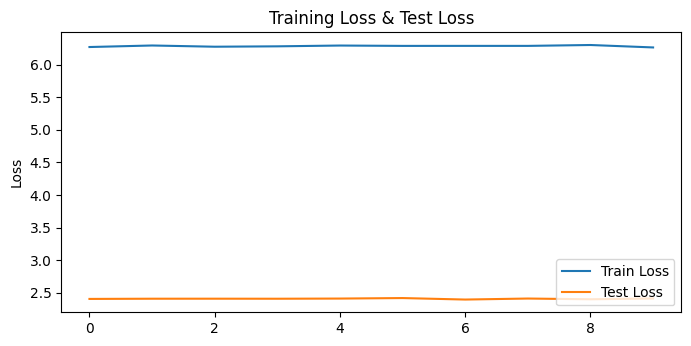

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
# plt.ylim([min(plt.ylim()),100])
plt.title('Training Loss & Test Loss')

Text(0.5, 1.0, 'Val loss Classify')

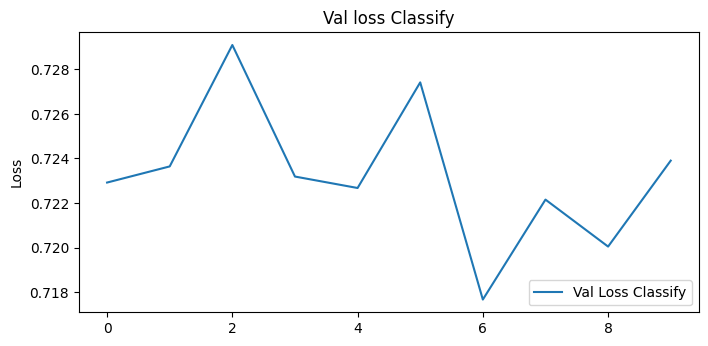

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(val_class_losses, label='Val Loss Classify')
plt.legend(loc='lower right')
plt.ylabel('Loss')
# plt.ylim([min(plt.ylim()),100])
plt.title('Val loss Classify')

Text(0.5, 1.0, 'Training Loss Regression')

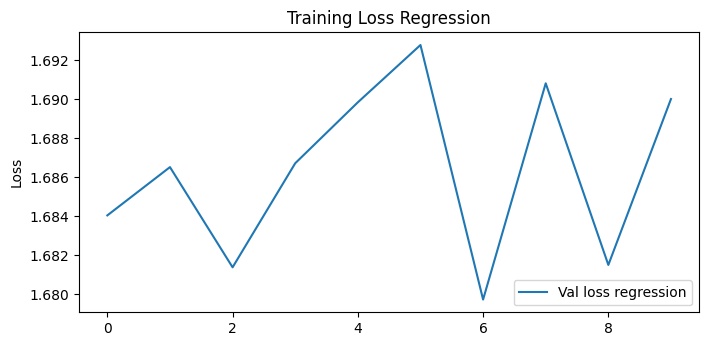

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(val_regress_losses, label='Val loss regression')
plt.legend(loc='lower right')
plt.ylabel('Loss')
# plt.ylim([min(plt.ylim()),100])
plt.title('Training Loss Regression')

Text(0.5, 1.0, 'Accuracy')

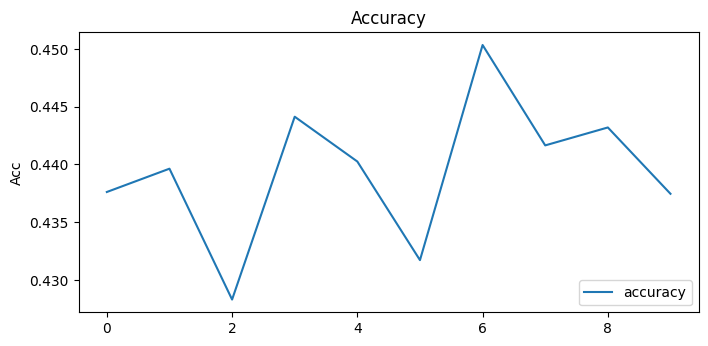

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accs, label='accuracy')
# plt.plot(f1_scores, label='f1_scores')
# plt.plot(r2_scores, label='r2_scores')
plt.legend(loc='lower right')
plt.ylabel('Acc')
# plt.ylim([min(plt.ylim()),100])
plt.title('Accuracy')

Text(0.5, 1.0, 'R2 Scores')

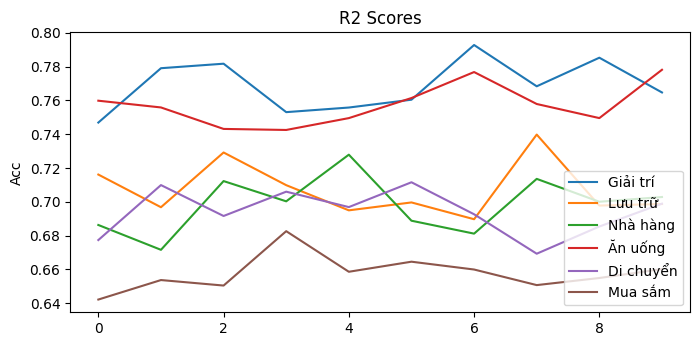

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot([scores[0] for scores in r2_scores], label='Giải trí')
plt.plot([scores[1] for scores in r2_scores], label='Lưu trữ')
plt.plot([scores[2] for scores in r2_scores], label='Nhà hàng')
plt.plot([scores[3] for scores in r2_scores], label='Ăn uống')
plt.plot([scores[4] for scores in r2_scores], label='Di chuyển')
plt.plot([scores[5] for scores in r2_scores], label='Mua sắm')

plt.legend(loc='lower right')
plt.ylabel('Acc')
# plt.ylim([min(plt.ylim()),100])
plt.title('R2 Scores')

Text(0.5, 1.0, 'F1 Scores')

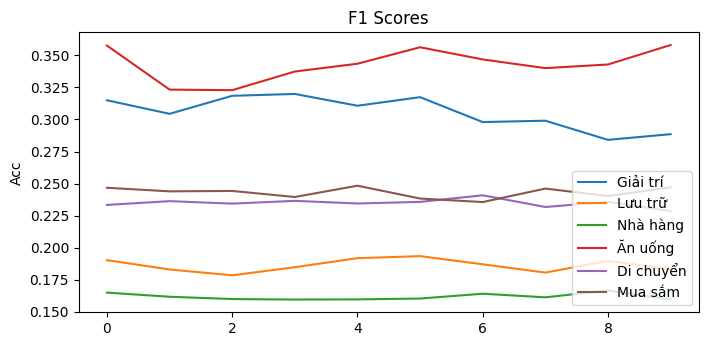

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot([scores[0] for scores in f1_scores], label='Giải trí')
plt.plot([scores[1] for scores in f1_scores], label='Lưu trữ')
plt.plot([scores[2] for scores in f1_scores], label='Nhà hàng')
plt.plot([scores[3] for scores in f1_scores], label='Ăn uống')
plt.plot([scores[4] for scores in f1_scores], label='Di chuyển')
plt.plot([scores[5] for scores in f1_scores], label='Mua sắm')

plt.legend(loc='lower right')
plt.ylabel('Acc')
# plt.ylim([min(plt.ylim()),100])
plt.title('F1 Scores')